# Image Segmentation with U-Net

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net

**Overview:**
U-Net is a type of CNN designed for quick, precise image segmentation, and used to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called **semantic image segmentation**. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by **labeling each pixel** in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption></img>

## U-Net Model Architecture

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network (FCN) which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary *because the dense layers destroy spatial information (the "where" of the image)*, which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It **also adds skip connections**, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption></img>

* **Contracting Path**: Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels. The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.
* **Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.
* **Expanding Path**: The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually. In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image. Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.
* **Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

In [1]:
import numpy as np
import pandas as pd
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [2]:
path = ''
image_path = os.path.join(path, 'data/unet_cars/CameraRGB/')
mask_path = os.path.join(path, 'data/unet_cars/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [3]:
image_list[:2], mask_list[:2]

(['data/unet_cars/CameraRGB/000026.png',
  'data/unet_cars/CameraRGB/000027.png'],
 ['data/unet_cars/CameraMask/000026.png',
  'data/unet_cars/CameraMask/000027.png'])

### Masked vs. Unmasked images

Text(0.5, 1.0, 'Segmentation')

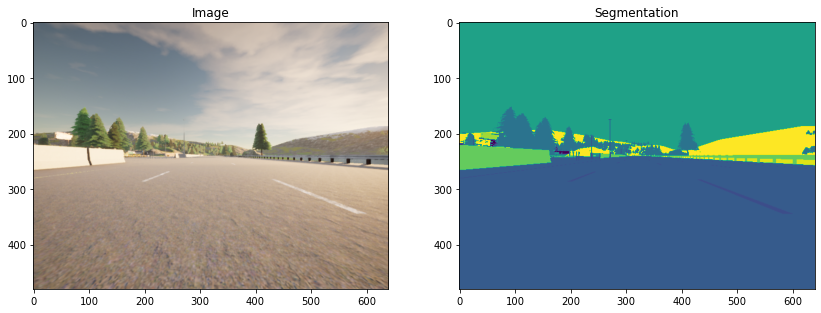

In [4]:
N = 4
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### Split dataset into Masked/ Unmasked images

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds  = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(2), mask_list_ds.take(2)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\unet_cars\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\unet_cars\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\unet_cars\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\unet_cars\\CameraMask\\000027.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/unet_cars/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'data/unet_cars/CameraMask/000026.png', shape=(), dtype=string)


### Preprocess Data

In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask  = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

### Downsampling Blocks (half the size of original paper)

In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(filters = n_filters,   # Number of filters
                  kernel_size = (3,3),   # Kernel size   
                  activation=tf.keras.activations.relu,
                  padding='same',
                  kernel_initializer=tf.keras.initializers.he_normal())(inputs)
    conv = Conv2D(filters = n_filters,   # Number of filters
                  kernel_size = (3,3),   # Kernel size
                  activation=tf.keras.activations.relu,
                  padding='same',
                  kernel_initializer=tf.keras.initializers.he_normal())(conv)
        
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### Upsampling Blocks

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 filters = n_filters,    # number of filters
                 kernel_size = (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 (3,3),        # Kernel size
                 activation=tf.keras.activations.relu,
                 padding='same',
                 kernel_initializer=tf.keras.initializers.he_normal())(merge)
    conv = Conv2D(n_filters,   # Number of filters
                 (3,3),        # Kernel size
                 activation=tf.keras.activations.relu,
                 padding='same',
                 kernel_initializer=tf.keras.initializers.he_normal())(conv)
    return conv

### Building the Model

In [10]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    
    conv9 = Conv2D(n_filters, 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(filters=n_classes, kernel_size=(1,1), padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [11]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


### Display Sample Images

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(96, 128, 1)


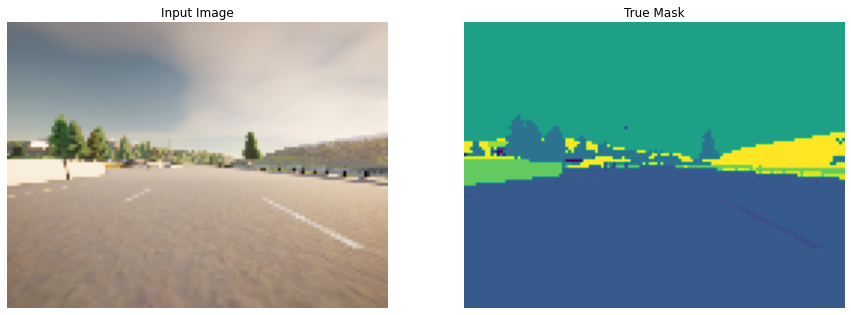

In [14]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## Train the Model

In [16]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

processed_image_ds.batch(BATCH_SIZE)

train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


In [18]:
model_history = unet.fit(train_dataset, epochs=EPOCHS)

Epoch 1/40
34/34 [==============================] - 29s 383ms/step - loss: 3.3884 - accuracy: 0.3251
Epoch 2/40
34/34 [==============================] - 8s 243ms/step - loss: 1.4850 - accuracy: 0.5577
Epoch 3/40
34/34 [==============================] - 8s 242ms/step - loss: 0.7860 - accuracy: 0.7820
Epoch 4/40
34/34 [==============================] - 8s 236ms/step - loss: 0.5513 - accuracy: 0.8419
Epoch 5/40
34/34 [==============================] - 8s 233ms/step - loss: 0.4534 - accuracy: 0.8674
Epoch 6/40
34/34 [==============================] - 8s 233ms/step - loss: 0.4536 - accuracy: 0.8673
Epoch 7/40
34/34 [==============================] - 8s 233ms/step - loss: 0.3906 - accuracy: 0.8875
Epoch 8/40
34/34 [==============================] - 8s 233ms/step - loss: 0.3365 - accuracy: 0.9017
Epoch 9/40
34/34 [==============================] - 8s 233ms/step - loss: 0.3013 - accuracy: 0.9122
Epoch 10/40
34/34 [==============================] - 8s 233ms/step - loss: 0.2872 - accuracy: 0.915

In [19]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

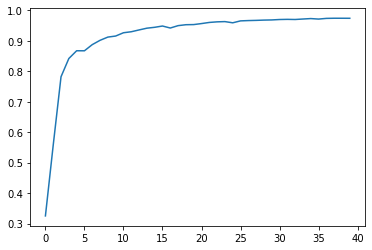

In [20]:
plt.plot(model_history.history["accuracy"])

### Predictions

In [21]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 230ms/step


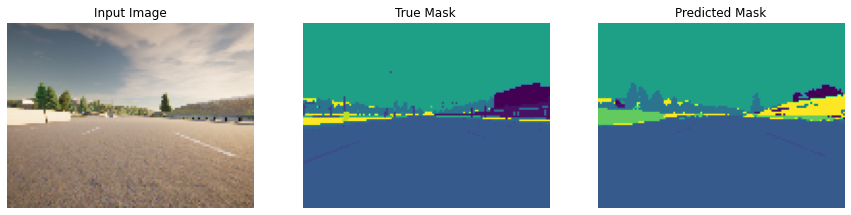

1/1 [==============================] - 0s 22ms/step


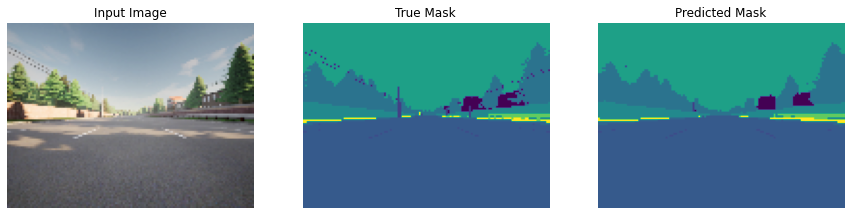

1/1 [==============================] - 0s 21ms/step


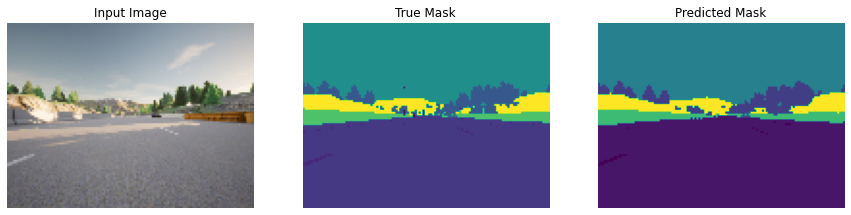

1/1 [==============================] - 0s 25ms/step


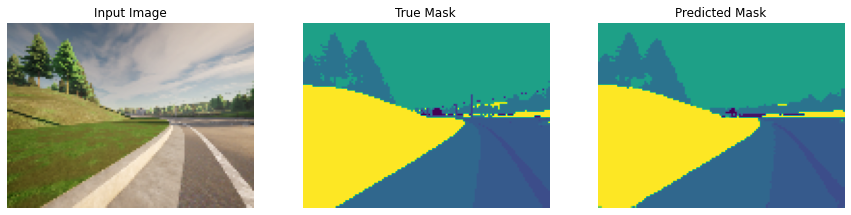

1/1 [==============================] - 0s 21ms/step


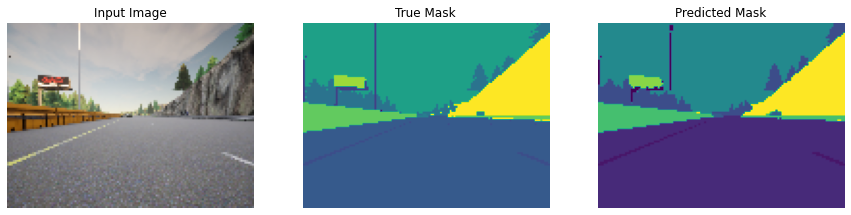

1/1 [==============================] - 0s 20ms/step


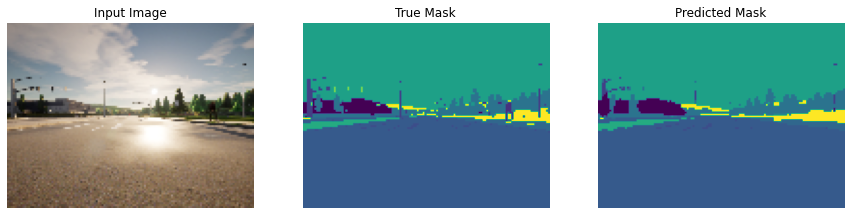

In [22]:
show_predictions(train_dataset, 6)